# Importing required packages

In [2]:
import pandas as pd
import sys
import os
from process import *
from process_coe_prices import *
from process_stock_prices import *
from process_main_dataset import *
from process_location_info import *

# Defining Local paths to datasets

In [3]:
datasets_path = "../../datasets"
train_input_path = f"{datasets_path}/train.csv"
test_input_path = f"{datasets_path}/test.csv"
mrt_input_path = f"{datasets_path}/auxiliary-data/sg-mrt-existing-stations.csv"
mrt_planned_input_path = f"{datasets_path}/auxiliary-data/sg-mrt-planned-stations.csv"
mall_input_path = f"{datasets_path}/auxiliary-data/sg-shopping-malls.csv"
school_input_path = f"{datasets_path}/auxiliary-data/sg-primary-schools.csv"
coe_input_path = f"{datasets_path}/auxiliary-data/sg-coe-prices.csv"
stocks_input_path = f"{datasets_path}/auxiliary-data/sg-stock-prices.csv"
town_centrality_input_path = f"{datasets_path}/auxiliary-data/additional-town-centrality-data/town_centroids_radius.csv"

# Getting the data from the auxiliary datasets

For more details about how we process the individual auxiliary datasets refer to the ipynb notebooks in /data/auxiliary datasets.

Once we get the values we add them as new columns in the original train dataset

In [4]:
# getting additional details from auxillary datasets
# process with coe
df_coe = transform_coe_prices(coe_input_path)

# process stock information
df_stocks = transform_stock_prices(stocks_input_path)

# first process and transform the dataset with the distance related values
df_with_locations = extract_distance_columns_from_aux_mrt_school_mall(train_input_path, mrt_input_path, mrt_planned_input_path, mall_input_path, school_input_path)

df_town_centrality = extract_town_centrality(mrt_input_path, mrt_planned_input_path, mall_input_path, school_input_path, town_centrality_input_path)

#combining all the dataframes
df_dirty = merge_dataframes(df_with_locations, df_coe, df_stocks, df_town_centrality)

Finished processing the COE Auxiliary dataset
Finished processing the Stock prices Auxiliary dataset
 : Started calculating the distance to nearest existing mrt
 : Finished calculating the distance to nearest existing mrt
 : Started calculating the distance to nearest planned mrt
 : Finished calculating the distance to nearest planned mrt
 : Started calculating the distance to nearest school
 : Finished calculating the distance to nearest school
 : Started calculating the distance to nearest mall
 : Finished calculating the distance to nearest mall
Finished processing the Town Importance and Centrality
Dataframes Merge Completed


## Checking out how the dataset looks like now

In [5]:
df_dirty.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,region,monthly_rent,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,distance_to_nearest_mall,coe_price_indicator,stock_price,town_importance,town_centrality_page_rank
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,west region,1600,699.127003,675.092874,334.846135,1202.673513,0.559383,0.888712,4.6,0.038323
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,...,east region,2250,898.991282,904.343701,607.716465,1114.338361,1.011901,0.549276,7.2,0.038414
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,...,central region,1900,218.603012,3716.441532,425.760160,468.296504,1.579188,0.496400,11.4,0.038819
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,...,east region,2850,1546.040421,516.218553,564.969272,402.358778,0.476939,0.887964,6.2,0.038298
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,...,central region,2100,187.855816,2831.638339,271.723351,1073.353709,1.764207,0.540721,19.2,0.038799


# Cleaning the dataset


## 1. Deleting unnecessary columns

### 1.1 elevation

All values are 0, therefore it makes sense to remove

![elevation](../../resources/useful_pics/elevation_all_zero.png)

In [6]:
df_delete = delete_column(df_dirty, "elevation")

Number of columns BEFORE elevation column deletion = 24
Number of columns AFTER elevation column deletion = 23


### 1.2 furnished

We see that all values under “furnished” column are “Yes”. This is data redundancy. We remove this column to improve our dataset.

![furnished](../../resources/useful_pics/furnished_all_yes.png)


In [7]:
# 1. delete columns
df_delete = delete_column(df_delete, "furnished")


Number of columns BEFORE furnished column deletion = 23
Number of columns AFTER furnished column deletion = 22


### 1.3 planning_area

We see that values under “planning_area” are usually the same as the values under the corresponding “town”. There are about 2 percent of the records which have a value under “planning_area” thta is different from the value under “town”. Hence we remove this column.

![planning_area](../../resources/useful_pics/planning_area_same_as_town.png)

In [8]:
#Count number of rows which have "planning_area" as a subset of "town"

count=0
for row in df_delete.itertuples():
  if(row.planning_area in row.town):
    count+=1
print("number of rows which have `planning_area` as a subset of `town` = ",count)

number of rows which have `planning_area` as a subset of `town` =  58807


In [9]:
df_delete = delete_column(df_delete, "planning_area")


Number of columns BEFORE planning_area column deletion = 22
Number of columns AFTER planning_area column deletion = 21


### 1.4 block

The block information is not required as we have lat, long and town , region information which can be used to train the model. Having this granular of information would mean we have to perform one hot encoding which will make our input data size a lot bigger.

Therefore, we are choosing to remove this column

In [10]:
df_delete = delete_column(df_delete, "block")


Number of columns BEFORE block column deletion = 21
Number of columns AFTER block column deletion = 20


### 1.5 street_name

Similar to block, there are a lot of street names which cannot be encoded reliably therefore we are choosing to delete this column as we dont require such granular information in the dataset for training any of the models

In [11]:
df_delete = delete_column(df_delete, "street_name")


Number of columns BEFORE street_name column deletion = 20
Number of columns AFTER street_name column deletion = 19


### 1.6 subzone

Similar to block & street name we are choosing to delete subzone information as in most of the cases the subtown exactly matches that of the town name.

In [12]:
df_delete = delete_column(df_delete, "subzone")

Number of columns BEFORE subzone column deletion = 19
Number of columns AFTER subzone column deletion = 18


## 2. Converting all string values to lower

This converts all columns with type string into lowercase

In [13]:
df_lower_case = df_delete.applymap(lambda x: x.lower() if isinstance(x, str) else x)

C:\Users\SRIRAM\AppData\Local\Temp\ipykernel_26240\2977471338.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_lower_case = df_delete.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [14]:
df_lower_case.head()

,rent_approval_date,town,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,region,monthly_rent,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,distance_to_nearest_mall,coe_price_indicator,stock_price,town_importance,town_centrality_page_rank
0,2021-09,jurong east,3 room,new generation,67.0,1983,1.344518,103.738630,west region,1600,699.127003,675.092874,334.846135,1202.673513,0.559383,0.888712,4.6,0.038323
1,2022-05,bedok,4-room,new generation,92.0,1978,1.330186,103.938717,east region,2250,898.991282,904.343701,607.716465,1114.338361,1.011901,0.549276,7.2,0.038414
2,2022-10,toa payoh,3-room,improved,67.0,1971,1.332242,103.845643,central region,1900,218.603012,3716.441532,425.760160,468.296504,1.579188,0.496400,11.4,0.038819
3,2021-08,pasir ris,executive,apartment,149.0,1993,1.370239,103.962894,east region,2850,1546.040421,516.218553,564.969272,402.358778,0.476939,0.887964,6.2,0.038298
4,2022-11,kallang/whampoa,3-room,improved,68.0,1972,1.320502,103.863341,central region,2100,187.855816,2831.638339,271.723351,1073.353709,1.764207,0.540721,19.2,0.038799


## 3. Converting the date to unix timestep

The rationale behind doing this is to ensure that we get a numerical value for date. Since the date might also have something to do with the prediction of monthly rent

In [15]:
df_lower_case['rent_approval_date'] = pd.to_datetime(df_lower_case['rent_approval_date'] + '-01', format='%Y-%m-%d')
df_lower_case['rent_approval_date'] = (df_lower_case['rent_approval_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)

In [16]:
df_lower_case['rent_approval_date'].head()

0    1630454400
1    1651363200
2    1664582400
3    1627776000
4    1667260800
Name: rent_approval_date, dtype: int64

## 4. Finding an ordinal value for flat type and flat model

### 4.1 Ordinalizing flat type

Normalize flat_type column. It replaces the string with the number of rooms.

Eg "3-rooms" will be "3". Only for "Executive" type we will replace it with an ordinal value of 6


In [17]:
df_ordinal_flat_type = ordinalize_flat_type(df_lower_case)



In [18]:
df_ordinal_flat_type["flat_type"].head()

0    3
1    4
2    3
3    6
4    3
Name: flat_type, dtype: int64

### 4.2 Ordinalizing the flat model ( while also considering flat type)

The code below first combines 'flat_type' and 'flat_model' columns, calculates the minimum and maximum values of 'floor_area_sqm' for each unique combination, and computes the average values. It then creates a new column 'flat_type_model' based on the average values. Finally, it drops the 'combined_column' and 'Flat_type_model' columns before returning the updated DataFrame.

The reason we went with this approach was because it was tricky to figure out an ordinality ranking with respect to flat model types as the model names are mostly arbitrary names chosen by different developers who developed different models over the course of time (<a href = "https://ugl.sg/wp-content/uploads/2020/08/HDB-history-photos-and-floor-plan-evolution-1930s-to-2010s-The-world-of-Teoalida.pdf">reference</a>).

Since we do not have domain knowledge in the real estate space it did not make sense to come up with an incorrect ordinal ranking, which is why we chose a naive approach of creating an ordinal ranking based on the floor square area ( as mentioned in the logic above)

In [19]:
df = df_ordinal_flat_type

#combining the flat-type and flat-model into one concatenated string
df['combined_column'] = df['flat_type'].astype(str) + df['flat_model'].str.replace(' ', '')
combined_values = df['combined_column'].unique()

# for each combination we are keeping track of the min and max values
flat_combos = dict()
for value in combined_values:
    min_val = df[df['combined_column'] == value]['floor_area_sqm'].min()
    max_val = df[df['combined_column'] == value]['floor_area_sqm'].max()
    flat_combos[value] = {
        "min_sqm": min_val,
        "max_sqm": max_val
    }

#find the average flat_sq area
for flat_combo in flat_combos.keys():
    flat_combos[flat_combo] = flat_combos[flat_combo]["min_sqm"] + flat_combos[flat_combo]["max_sqm"]

#sort by flat sq area
flat_combo_ordinal = {}
sort_flat_combos_by_area = sorted(flat_combos.items(), key=lambda combo: combo[1])

#find the ordinalily by finding the index of the flat combo after sorting by avg sqm
for item in sort_flat_combos_by_area:
    flat_combo, avg_sqm = item
    flat_combo_ordinal[flat_combo] = sort_flat_combos_by_area.index(item)

df['flat_type_model'] = df.apply(lambda x: flat_combo_ordinal[str(x['combined_column'])], axis=1)

#deleting unnecessary columns
df = delete_column(df, 'combined_column')
df_flat_type_ordinality = delete_column(df, 'flat_model')

Number of columns BEFORE combined_column column deletion = 20
Number of columns AFTER combined_column column deletion = 19
Number of columns BEFORE flat_model column deletion = 19
Number of columns AFTER flat_model column deletion = 18


In [20]:
df_flat_type_ordinality["flat_type_model"].head()

0    13
1    23
2     8
3    35
4     8
Name: flat_type_model, dtype: int64

## 5. One hot encoding

### 5.1 One hot encoding region

Since there are only 5 regions it makes sense to one hot encode them as it may be useful for the model to figure out a more generic pattern

In [21]:
df_onehot = pd.get_dummies(df_flat_type_ordinality, columns=['region'], prefix=['region'])

### 5.2 One hot encoding town

Since the town information is important to our algorithm we are one hot encoding the 26 unique towns present in the dataset

In [22]:
df_onehot = pd.get_dummies(df_onehot, columns=['town'], prefix=['town'])

In [23]:
df = df_onehot

# 6. Importance Scores and Centrality (Page Rank) Scores for each "Town"

A key factor that would decide the rent of a home would be the area or town. Hence we wanted to <b> quantify the "importance" of an area </b>. We drew inspiration from this course's <b> lecture 10 : Graph Mining </b>. The idea of Centrality would suit our goal of assigning "importance score" to towns.

 But apart from assigning "importance score" to towns, we also wanted to factor in "how close is this town (which might have an importance score that is low or high) to a town that is of high importance. <b> The town by itself may not be a hotspot, but if it's just a kilometre away from a very important area, then it should still receive some form of a reward </b>. Being half a kilometre away from Marina Bay would have more weightage that being half a kilometre away from a relatively not-so-important area.

<h4> A custom dataset was compiled for this task - The town_centroid_radius.csv dataset </h4>

The given original train dataset had 26 unique towns in total

In [24]:
original_input_path = f"{datasets_path}/train.csv"
test_input_path = f"{datasets_path}/test.csv"
df_original = pd.read_csv(original_input_path)

df_original['town'].value_counts()

town
jurong west        4413
tampines           4183
sengkang           4003
bedok              3644
ang mo kio         3494
yishun             3378
bukit merah        3160
woodlands          3031
hougang            2859
punggol            2700
toa payoh          2407
clementi           2272
bukit batok        2236
choa chu kang      2117
queenstown         2033
kallang/whampoa    1860
geylang            1716
pasir ris          1712
jurong east        1710
bukit panjang      1607
sembawang          1446
bishan             1437
serangoon          1299
central             615
marine parade       612
bukit timah          56
Name: count, dtype: int64

For each of these 26 towns, the town centroid was found using google maps. The centroid_lat and centroid_long was found along with the approximate town radius and the 'town_centroid_radius.csv' dataset was created. Images for other towns can be found in 'resources/town_centroid_radius_pictures.pdf' document.


![clementi](../../resources/useful_pics/clementi_radius.png)

In this project, this dataset can be found in 'datasets/auxiliary-data/additional-town-centrality-data'

![clementi](../../resources/useful_pics/town_dataset.png)

The newly created dataset was used to find the importance and centrality of towns.

The importance of a town was determined the following manner:
importance = 
(no. of MRTs existing within radius * 0.4) 
+(no. of MRTs planned within radius * 0.2) + 
+(no. of schools within radius * 0.2 )
+(no. of malls within radius * 0.2 )

To determine what would be a reasonable radius for all towns, we took the mean of the town radius column which was 2.730 KM. Hence we considered 2.7km or 2700m as the radius. If an entity such as MRT or a school is within this distance (Haversine distance) from the town's centre, then we added that entity to the town's count.
The process_location_info.ipynb has more details about Haversine distance.

We wanted to provide higher weightage to existing MRTs, hence in the formula the weightage for no. of existing MRTs would be 0.4, while it would be 0.2 for planned MRTs, schools and malls.

Now to find the "Page Rank" of towns.
For this, a simplified implementation of page rank was used.

The importance scores would be the score obtained from the above formula.
The distance matrix (instead of adjacency matrix) was the pair-wise haversine distance between towns.

The implementation can be found in our 'extract_town_centrality' method which has been imported in the below cell.




In [25]:
town_centrality_input_path = f"{datasets_path}/auxiliary-data/additional-town-centrality-data/town_centroids_radius.csv"

df_towns = extract_town_centrality(mrt_input_path, mrt_planned_input_path, mall_input_path, school_input_path, town_centrality_input_path)

df_towns.head()

Finished processing the Town Importance and Centrality


,town,importance,centrality_page_rank
0,jurong west,7.2,0.038138
1,tampines,9.8,0.038302
2,sengkang,7.6,0.038480
3,bedok,7.2,0.038414
4,ang mo kio,4.8,0.038558


And then the columns were merged with the original dataset based on the town name. The merging of these two columns into the original dataset was done along other columns that were extracted from auxiliary data such as 'stock_price', 'coe_prices', 'distance_to_nearest_existing_mrt' and so on

In [26]:
df.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,monthly_rent,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,...,town_pasir ris,town_punggol,town_queenstown,town_sembawang,town_sengkang,town_serangoon,town_tampines,town_toa payoh,town_woodlands,town_yishun
0,1630454400,3,67.0,1983,1.344518,103.738630,1600,699.127003,675.092874,334.846135,...,False,False,False,False,False,False,False,False,False,False
1,1651363200,4,92.0,1978,1.330186,103.938717,2250,898.991282,904.343701,607.716465,...,False,False,False,False,False,False,False,False,False,False
2,1664582400,3,67.0,1971,1.332242,103.845643,1900,218.603012,3716.441532,425.760160,...,False,False,False,False,False,False,False,True,False,False
3,1627776000,6,149.0,1993,1.370239,103.962894,2850,1546.040421,516.218553,564.969272,...,True,False,False,False,False,False,False,False,False,False
4,1667260800,3,68.0,1972,1.320502,103.863341,2100,187.855816,2831.638339,271.723351,...,False,False,False,False,False,False,False,False,False,False


## 7. Removing duplicate rows

In [27]:
df_no_duplicate = duplicate(df_onehot)

Number of duplicates =  523
Number of rows before duplicate deletion =  60000
Number of rows after duplicate deletion =  59477


# Ensuring that columns are normalized

The following columns need to be normalized:
1. rent_approval_date: as it is now a unix timestamp
2. lease_commense_date: as it is just an year value
3. floor_area_sqm
4. all the distance values computed to mrt, school and malls
5. coe_price_indicator (from auxiliary dataset)
6. stock_price (from auxiliary dataset)

In [ ]:
df_unnormalized = normalize_column(df_no_duplicate, "rent_approval_date")
df_unnormalized = normalize_column(df_unnormalized, "lease_commence_date")
df_unnormalized = normalize_column(df_unnormalized, "floor_area_sqm")
df_unnormalized = normalize_column(df_unnormalized, "distance_to_nearest_existing_mrt")
df_unnormalized = normalize_column(df_unnormalized, "distance_to_nearest_planned_mrt")
df_unnormalized = normalize_column(df_unnormalized, "distance_to_nearest_school")
df_unnormalized = normalize_column(df_unnormalized, "distance_to_nearest_mall")
df_unnormalized = normalize_column(df_unnormalized, "coe_price_indicator")
df_normalized = normalize_column(df_unnormalized, "stock_price")
df_unnormalized = normalize_column(df_unnormalized, "flat_type")
df_unnormalized = normalize_column(df_unnormalized, "flat_type_model")
df_normalized = normalize_column(df_unnormalized, "town_importance")

# Checking out how the final cleaned dataset looks like

In [29]:
df_normalized.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,monthly_rent,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,...,town_pasir ris,town_punggol,town_queenstown,town_sembawang,town_sengkang,town_serangoon,town_tampines,town_toa payoh,town_woodlands,town_yishun
0,0.266740,0.25,0.182320,0.320755,1.344518,103.738630,1600,0.271900,0.067848,0.143355,...,False,False,False,False,False,False,False,False,False,False
1,0.532382,0.50,0.320442,0.226415,1.330186,103.938717,2250,0.353866,0.092239,0.277286,...,False,False,False,False,False,False,False,False,False,False
2,0.700329,0.25,0.182320,0.094340,1.332242,103.845643,1900,0.074831,0.391439,0.187977,...,False,False,False,False,False,False,False,True,False,False
3,0.232711,1.00,0.635359,0.509434,1.370239,103.962894,2850,0.619229,0.050944,0.256304,...,True,False,False,False,False,False,False,False,False,False
4,0.734358,0.25,0.187845,0.113208,1.320502,103.863341,2100,0.062221,0.297298,0.112373,...,False,False,False,False,False,False,False,False,False,False


## And in this final data, we generated a pandas profile report which can be found in 'resources/after_eda_analysis_report/train_clean_report_after_eda'.

The pearson correlation section of the report that is shown below indicated that the columns we created such as 'stock_price', 'coe_price', 'town_importance', 'town_centrality' have a decent-good degree of correlation with other features which are correlated to monthly rent .

![](../../resources/useful_pics/pearson_corr.png)

But since pearson correlation only considers linear relationships, we also used Spearman correlation to get a better understanding of the non-linear relationships.

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
spearman_corr = df_normalized.corr(method='spearman')


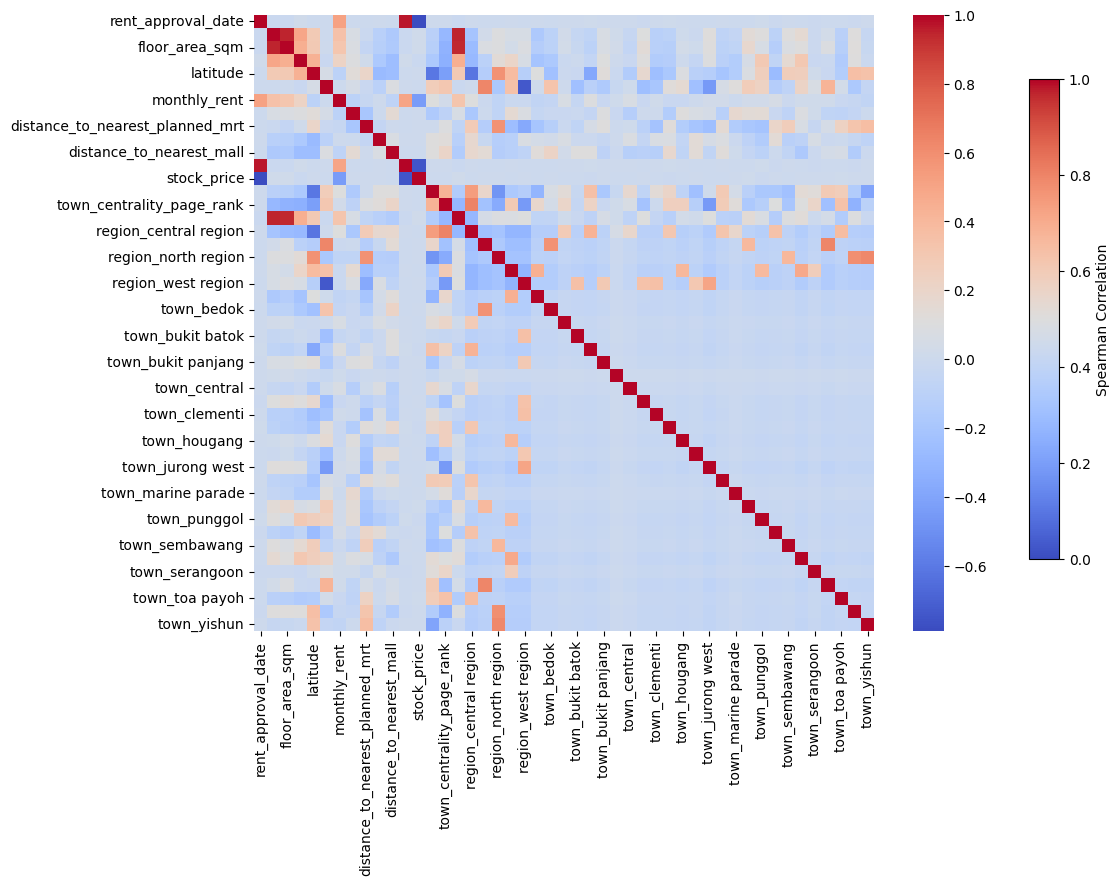

In [46]:
plt.figure(figsize=(10, 8))

sns.heatmap(spearman_corr, cmap='coolwarm', )

cax = plt.gcf().add_axes([0.9, 0.2, 0.03, 0.6])
sm = plt.cm.ScalarMappable(cmap='coolwarm')
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)

cbar.set_label('Spearman Correlation')


We can see that the newly added columns have a decent amount of Pearson and Spearman correlation with the dataset in general. Hence we proceeded to train our models with this cleaned version of the train data.